In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/craigslist-vehicles/craigslist_vehicles.csv


In [2]:
%pip install pyforest
import pyforest

  Preparing metadata (setup.py) ... - \ | done
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14606 sha256=09161f291ef04e37b5ebd9d29b039a9d2e4f200b7cd47354a6c374a150fa067e
  Stored in directory: /root/.cache/pip/wheels/9e/7d/2c/5d2f5e62de376c386fd3bf5a8e5bd119ace6a9f48f49df6017
Successfully built pyforest
Note: you may need to restart the kernel to use updated packages.


In [3]:
data = pd.read_csv('/kaggle/input/craigslist-vehicles/craigslist_vehicles.csv')

In [4]:
data.info(), data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    426880 non-null  int64  
 1   id            426880 non-null  int64  
 2   url           426880 non-null  object 
 3   region        426880 non-null  object 
 4   region_url    426880 non-null  object 
 5   price         426880 non-null  int64  
 6   year          425675 non-null  float64
 7   manufacturer  409234 non-null  object 
 8   model         421603 non-null  object 
 9   condition     252776 non-null  object 
 10  cylinders     249202 non-null  object 
 11  fuel          423867 non-null  object 
 12  odometer      422480 non-null  float64
 13  title_status  418638 non-null  object 
 14  transmission  424324 non-null  object 
 15  VIN           265838 non-null  object 
 16  drive         296313 non-null  object 
 17  size          120519 non-null  object 
 18  type

(None, (426880, 28))

In [5]:
data.isnull().sum()

Unnamed: 0           0
id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
removal_date        68
dtype: int64

In [6]:
cols_drop = ['Unnamed: 0','url','image_url', 'county', 'region_url', 'paint_color','size', 'drive', 'VIN']

In [7]:
data.drop(data[cols_drop], axis=1, inplace=True)

In [8]:
data.isnull().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
type             92858
description         70
state                0
lat               6549
long              6549
posting_date        68
removal_date        68
dtype: int64

In [9]:
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,type,description,state,lat,long,posting_date,removal_date
0,7307679724,abilene,4500,2002.0,bmw,x5,NaN,NaN,gas,184000.0,clean,automatic,NaN,"$4,500 Cash 2002 BMW X5 8 cylinder 4.4L moto...",tx,32.401556,-99.884713,2021-04-16 00:00:00+00:00,2021-05-02 00:00:00+00:00
1,7311833696,abilene,4500,2002.0,bmw,x5,NaN,NaN,gas,184000.0,clean,automatic,NaN,"$4,500 Cash 2002 BMW X5 8 cylinder 4.4L moto...",tx,32.401556,-99.884713,2021-04-24 00:00:00+00:00,2021-04-28 00:00:00+00:00
2,7311441996,abilene,4900,2006.0,toyota,camry,excellent,4 cylinders,gas,184930.0,clean,automatic,sedan,2006 TOYOTA CAMRY LE Sedan Ready To Upgrade ...,tx,32.453848,-99.787900,2021-04-23 00:00:00+00:00,2021-05-25 00:00:00+00:00
3,7307680715,abilene,6500,2008.0,ford,expedition,NaN,NaN,gas,206000.0,clean,automatic,NaN,$6500.00 2008 Ford Expedition 8 cylinder 5.4L...,tx,32.401556,-99.884713,2021-04-16 00:00:00+00:00,2021-04-26 00:00:00+00:00
4,7311834578,abilene,6500,2008.0,ford,expedition,NaN,NaN,gas,206000.0,clean,automatic,NaN,$6500.00 2008 Ford Expedition 8 cylinder 5.4L...,tx,32.401556,-99.884713,2021-04-24 00:00:00+00:00,2021-05-12 00:00:00+00:00


In [10]:
data.cylinders.value_counts()

cylinders
6 cylinders     94169
4 cylinders     77642
8 cylinders     72062
5 cylinders      1712
10 cylinders     1455
other            1298
3 cylinders       655
12 cylinders      209
Name: count, dtype: int64

In [11]:
def fill_missing(df):
    # Separate columns by data type (numeric and object)
    numeric_features = []
    categorical_features = []

    for i in df.columns:
        if df[i].dtype == 'object':
            categorical_features.append(i)
        else:
            numeric_features.append(i)

    # Fill missing values in numeric columns with the median
    df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

    # Fill missing values in object columns with the mode
    df[categorical_features] = df[categorical_features].fillna(df[categorical_features].mode().iloc[0])


    return df


In [12]:
data = fill_missing(data)

In [13]:
data.isnull().sum()

id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
type            0
description     0
state           0
lat             0
long            0
posting_date    0
removal_date    0
dtype: int64

In [14]:
data.posting_date = pd.to_datetime(data.posting_date)

In [15]:
data.info(((((((())))))))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   id            426880 non-null  int64              
 1   region        426880 non-null  object             
 2   price         426880 non-null  int64              
 3   year          426880 non-null  float64            
 4   manufacturer  426880 non-null  object             
 5   model         426880 non-null  object             
 6   condition     426880 non-null  object             
 7   cylinders     426880 non-null  object             
 8   fuel          426880 non-null  object             
 9   odometer      426880 non-null  float64            
 10  title_status  426880 non-null  object             
 11  transmission  426880 non-null  object             
 12  type          426880 non-null  object             
 13  description   426880 non-null  object       

In [16]:
data.set_index('posting_date', inplace=True)

In [17]:
data.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,type,description,state,lat,long,removal_date
posting_date,,,,,,,,,,,,,,,,,,
2021-04-16 00:00:00+00:00,7307679724,abilene,4500,2002.0,bmw,x5,good,6 cylinders,gas,184000.0,clean,automatic,sedan,"$4,500 Cash 2002 BMW X5 8 cylinder 4.4L moto...",tx,32.401556,-99.884713,2021-05-02 00:00:00+00:00
2021-04-24 00:00:00+00:00,7311833696,abilene,4500,2002.0,bmw,x5,good,6 cylinders,gas,184000.0,clean,automatic,sedan,"$4,500 Cash 2002 BMW X5 8 cylinder 4.4L moto...",tx,32.401556,-99.884713,2021-04-28 00:00:00+00:00
2021-04-23 00:00:00+00:00,7311441996,abilene,4900,2006.0,toyota,camry,excellent,4 cylinders,gas,184930.0,clean,automatic,sedan,2006 TOYOTA CAMRY LE Sedan Ready To Upgrade ...,tx,32.453848,-99.787900,2021-05-25 00:00:00+00:00
2021-04-16 00:00:00+00:00,7307680715,abilene,6500,2008.0,ford,expedition,good,6 cylinders,gas,206000.0,clean,automatic,sedan,$6500.00 2008 Ford Expedition 8 cylinder 5.4L...,tx,32.401556,-99.884713,2021-04-26 00:00:00+00:00
2021-04-24 00:00:00+00:00,7311834578,abilene,6500,2008.0,ford,expedition,good,6 cylinders,gas,206000.0,clean,automatic,sedan,$6500.00 2008 Ford Expedition 8 cylinder 5.4L...,tx,32.401556,-99.884713,2021-05-12 00:00:00+00:00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

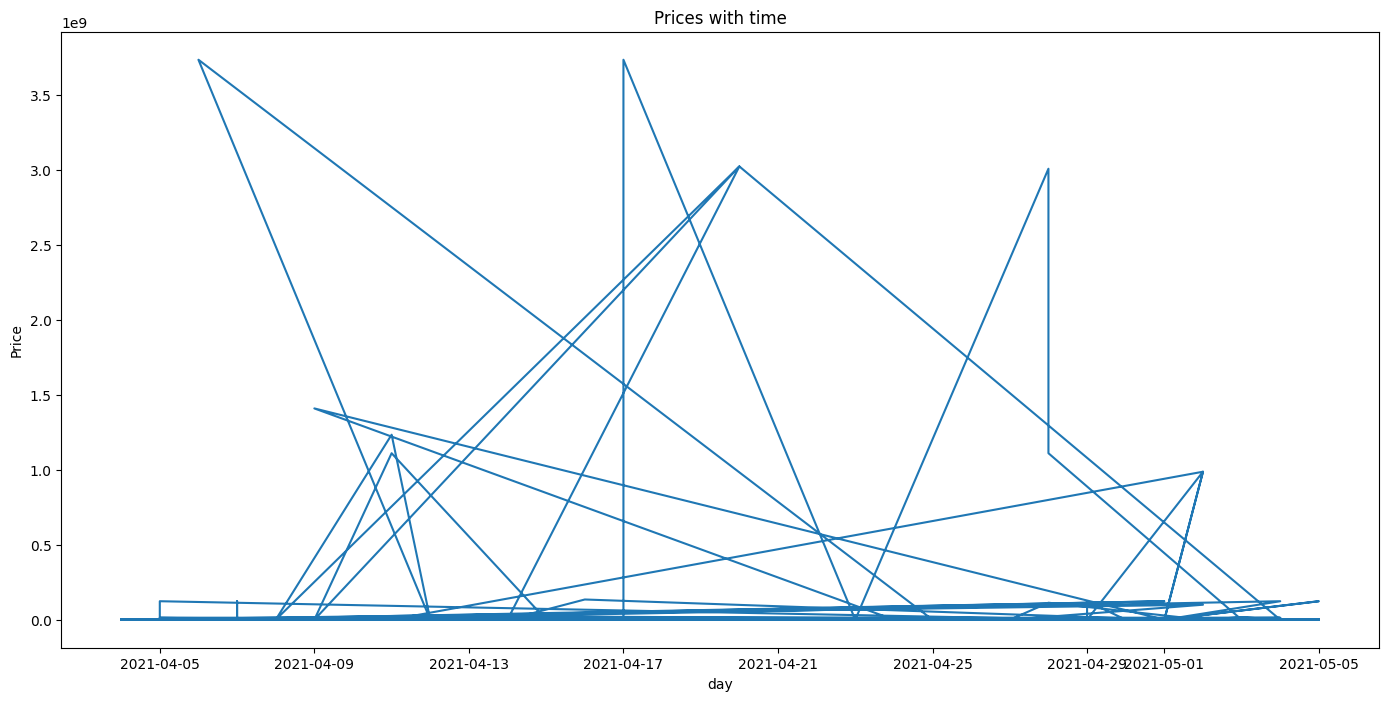

In [18]:
plt.figure(figsize=(17, 8))
plt.plot(data.price)
plt.title('Prices with time')
plt.ylabel('Price')
plt.xlabel('day')
plt.grid(False)
plt.show()

In [19]:
df_agg = data.groupby(['region', 'type', 'posting_date']).size().reset_index(name='count')
# df_agg = df_agg.sort_values(by='posting_date')
# df_freq = data.groupby(pd.Grouper(key='posting_date', freq='D')).sum().reset_index()

In [20]:
df_agg = df_agg.sort_values(by='posting_date')
df_agg.head()

,region,type,posting_date,count
47326,rochester,coupe,2021-04-04 00:00:00+00:00,4
13306,dayton / springfield,sedan,2021-04-04 00:00:00+00:00,4
1590,anchorage / mat-su,wagon,2021-04-04 00:00:00+00:00,1
13367,dayton / springfield,van,2021-04-04 00:00:00+00:00,1
36157,missoula,SUV,2021-04-04 00:00:00+00:00,1


In [21]:
df_freq = df_agg.groupby(pd.Grouper(key='posting_date', freq='D')).sum().reset_index()

In [22]:
df_freq = df_agg.groupby(pd.Grouper(key='posting_date', freq='D')).sum().reset_index()

fig_freq = go.Figure(data=go.Bar(
    x=df_freq['posting_date'],
    y=df_freq['count'],
    marker_color='royalblue',
    opacity=0.8
))

fig_freq.update_layout(
    title='Time Frequency Graph: Number of Vehicle Listings per Day',
    xaxis_title='Posting Date',
    yaxis_title='Number of Vehicle Listings',
    xaxis_tickangle=-45,
)
fig_freq.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
#Daily Average price

daily_average = data['price'].resample('D').mean()

In [24]:
display(daily_average.head())

print("\n\nAggregates mean prices for each day")

posting_date
2021-04-04 00:00:00+00:00     23120.747228
2021-04-05 00:00:00+00:00     42300.160571
2021-04-06 00:00:00+00:00    544212.541373
2021-04-07 00:00:00+00:00     35742.916852
2021-04-08 00:00:00+00:00     19072.463539
Freq: D, Name: price, dtype: float64



Aggregates mean prices for each day


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

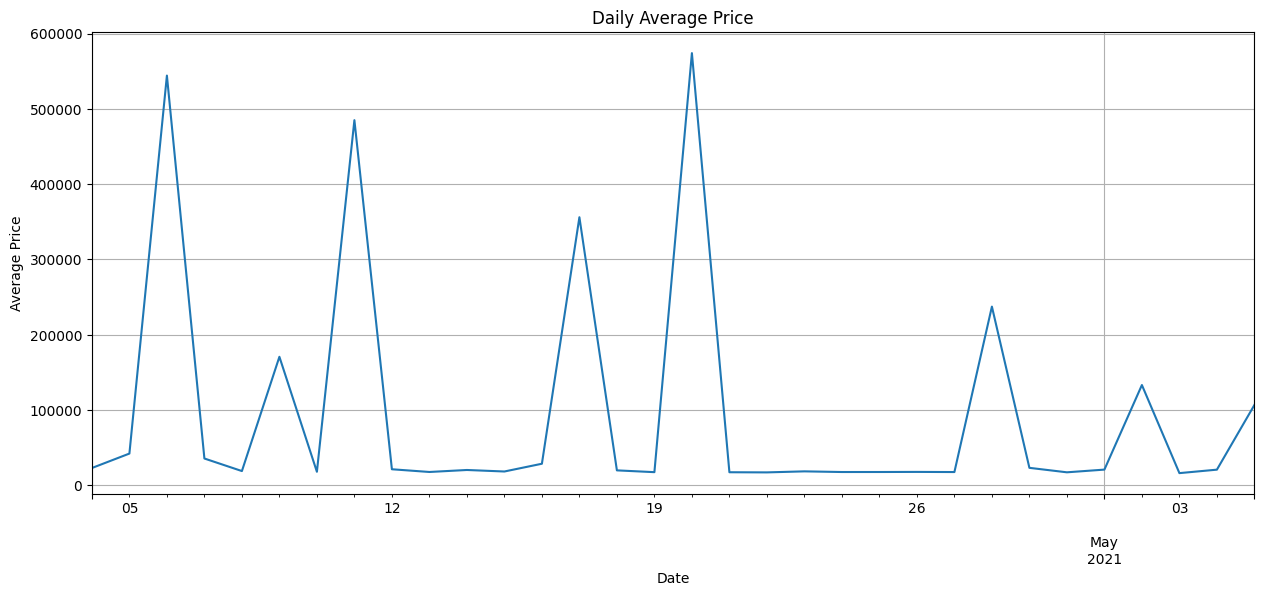

In [25]:
plt.figure(figsize=(15, 6))
daily_average.plot()
plt.title('Daily Average Price')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

In [26]:
## Monthly Average

Monthly_average = data.price.resample('M').mean()

display(Monthly_average)
print("\n\n The Data only covers two months ")

posting_date
2021-04-30 00:00:00+00:00    88622.679119
2021-05-31 00:00:00+00:00    38240.337773
Freq: M, Name: price, dtype: float64



 The Data only covers two months 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

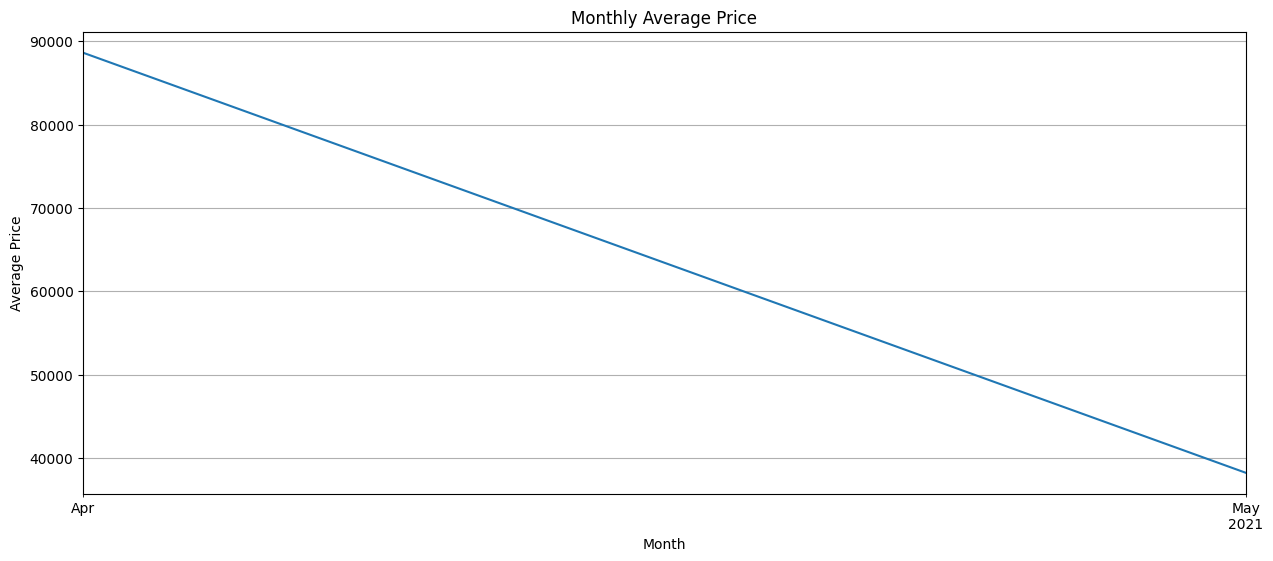

In [27]:
plt.figure(figsize=(15, 6))
Monthly_average.plot()
plt.title('Monthly Average Price')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()

In [28]:
## Hourly Average

hourly_average = data.price.resample('H').mean()
display(hourly_average)


posting_date
2021-04-04 00:00:00+00:00     23120.747228
2021-04-04 01:00:00+00:00              NaN
2021-04-04 02:00:00+00:00              NaN
2021-04-04 03:00:00+00:00              NaN
2021-04-04 04:00:00+00:00              NaN
                                 ...      
2021-05-04 20:00:00+00:00              NaN
2021-05-04 21:00:00+00:00              NaN
2021-05-04 22:00:00+00:00              NaN
2021-05-04 23:00:00+00:00              NaN
2021-05-05 00:00:00+00:00    106818.047689
Freq: H, Name: price, Length: 745, dtype: float64

In [29]:
print("\n\n Looks like cars were not sold Every hour")



 Looks like cars were not sold Every hour


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

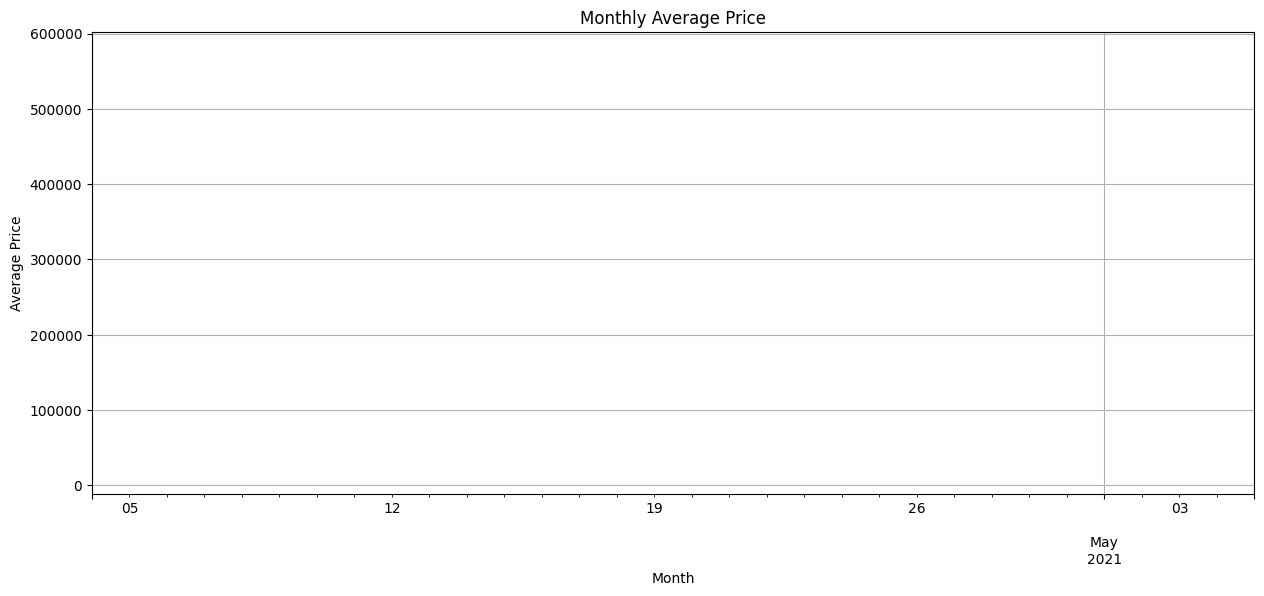

In [30]:
plt.figure(figsize=(15, 6))
hourly_average.plot()
plt.title('Monthly Average Price')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.grid(True)
plt.show()